# Bank Marketing Analysis with CatBoost

This notebook demonstrates how to:
1. Load the Bank Marketing dataset (handling ARFF format).
2. Train a **CatBoostClassifier** which natively handles categorical features.
3. Evaluate model performance.
4. Visualize Feature Importance.

In [8]:
# Install CatBoost
# !pip install catboost pandas numpy matplotlib scikit-learn

In [17]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

## 1. Load Data

In [10]:
columns = [
    "age", "job", "marital", "education", "default", "balance", "housing",
    "loan", "contact", "day", "month", "duration", "campaign", "pdays",
    "previous", "poutcome", "y"
]

# Load data using pandas read_csv, skipping ARFF header (approx 24 lines)
df = pd.read_csv('../datasets/banking_deposit_subscription/dataset', skiprows=24, header=None, names=columns)

# Clean up string columns (remove extra quotes if present)
for col in df.select_dtypes([object]):
    df[col] = df[col].str.replace("'", "").str.strip()

print("Shape:", df.shape)
df.head()

Shape: (45209, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
1,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
2,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
3,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
4,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no


In [11]:
import io

buffer = io.StringIO()
df.info(buf=buffer)
info_str = buffer.getvalue()


In [12]:
df.head().to_string()

'   age           job  marital  education default  balance housing loan  contact  day month  duration  campaign  pdays  previous poutcome   y\n0   33  entrepreneur  married  secondary      no        2     yes  yes  unknown    5   may        76         1     -1         0  unknown  no\n1   47   blue-collar  married    unknown      no     1506     yes   no  unknown    5   may        92         1     -1         0  unknown  no\n2   33       unknown   single    unknown      no        1      no   no  unknown    5   may       198         1     -1         0  unknown  no\n3   35    management  married   tertiary      no      231     yes   no  unknown    5   may       139         1     -1         0  unknown  no\n4   28    management   single   tertiary      no      447     yes  yes  unknown    5   may       217         1     -1         0  unknown  no'

## 1.1 Feature Understanding with LLM

We use an LLM to analyze the dataframe columns and a few sample rows to generate a brief explanation for each feature.

In [ ]:
import openai
import os

# Setup OpenAI API Key
openai.api_key = os.getenv("OPENAI_API_KEY")

def explain_features_with_llm(df, n_rows=5):
    if not openai.api_key:
        return "Error: OpenAI API Key not set."
    
    columns = df.columns.tolist()
    sample_data = df.head(n_rows).to_string(index=False)
    
    prompt = f"""
    I have a dataset with the following columns: {columns}
    
    Here are the first {n_rows} rows of the data:
    {sample_data}
    
    Please provide a short, one-line explanation for each feature (column) describing what it likely represents based on its name and values.
    Format as a bulleted list.
    """
    
    try:
        response = openai.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are a helpful data scientist."}, 
                {"role": "user", "content": prompt}
            ],
            temperature=0.2
        )
        return response.choices[0].message.content
    except Exception as e:
        return f"OpenAI API Error: {str(e)}"

In [5]:
print("Feature explanations:\n")
explanation = explain_features_with_llm(df)
print(explanation)

Feature explanations:

- **age**: The age of the individual in years.
- **job**: The type of job the individual holds, such as "entrepreneur" or "blue-collar."
- **marital**: The marital status of the individual, such as "married" or "single."
- **education**: The highest level of education attained by the individual, such as "secondary" or "tertiary."
- **default**: Indicates whether the individual has credit in default, typically "yes" or "no."
- **balance**: The account balance of the individual, likely in monetary units.
- **housing**: Indicates whether the individual has a housing loan, typically "yes" or "no."
- **loan**: Indicates whether the individual has a personal loan, typically "yes" or "no."
- **contact**: The type of communication used to contact the individual, such as "unknown."
- **day**: The day of the month when the last contact was made.
- **month**: The month when the last contact was made, such as "may."
- **duration**: The duration of the last contact in seconds

## 2. Preprocessing
CatBoost handles categorical features automatically. We just need to:
1. Encode the target `y` to 0/1.
2. Identify the indices/names of categorical columns for CatBoost.

In [13]:
# Encode target
df['y'] = df['y'].map({'yes': 1, 'no': 0})

# Identify categorical features (excluding target)
cat_features = df.drop('y', axis=1).select_dtypes(include=['object']).columns.tolist()
print("Categorical features:", cat_features)

X = df.drop('y', axis=1)
y = df['y']

Categorical features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


## 3. Train/Test Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (36167, 16)
Test shape: (9042, 16)


## 4. Train CatBoost Model

In [15]:
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=100,
    eval_metric='AUC',
    random_seed=42
)

# We strictly pass cat_features names here
model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_test, y_test))

0:	test: 0.8644157	best: 0.8644157 (0)	total: 74.7ms	remaining: 37.3s
100:	test: 0.9316090	best: 0.9316090 (100)	total: 1.29s	remaining: 5.11s
200:	test: 0.9344576	best: 0.9344875 (195)	total: 2.43s	remaining: 3.62s
300:	test: 0.9354483	best: 0.9354483 (300)	total: 3.61s	remaining: 2.39s
400:	test: 0.9357126	best: 0.9357415 (396)	total: 4.84s	remaining: 1.2s
499:	test: 0.9355518	best: 0.9357909 (410)	total: 6.03s	remaining: 0us

bestTest = 0.9357908871
bestIteration = 410

Shrink model to first 411 iterations.


In [18]:
os.makedirs('models', exist_ok=True)
model.save_model("models/catboost_model.cbm")
print("Model saved to models/catboost_model.cbm")

Model saved to models/catboost_model.cbm


In [19]:
model = CatBoostClassifier()
model.load_model('models/catboost_model.cbm')

## 5. Evaluation

In [20]:
# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {acc:.4f}")
print(f"ROC AUC: {roc:.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9113
ROC AUC: 0.9358

Confusion Matrix:
[[7721  263]
 [ 539  519]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7984
           1       0.66      0.49      0.56      1058

    accuracy                           0.91      9042
   macro avg       0.80      0.73      0.76      9042
weighted avg       0.90      0.91      0.91      9042



In [21]:
# Find optimal threshold
best_threshold = 0.5
max_f1 = 0
for t in [0.2, 0.3, 0.4, 0.5]:
    y_pred_t = (y_prob >= t).astype(int)
    report = classification_report(y_test, y_pred_t, digits=3, output_dict=True)
    f1 = report["1"]['f1-score']
    if f1 > max_f1:
        max_f1 = f1
        best_threshold = t

print(f"Best threshold: {best_threshold}")
print(f"Max f1: {max_f1}")

Best threshold: 0.2
Max f1: 0.640087783467447


## 6. Feature Importance

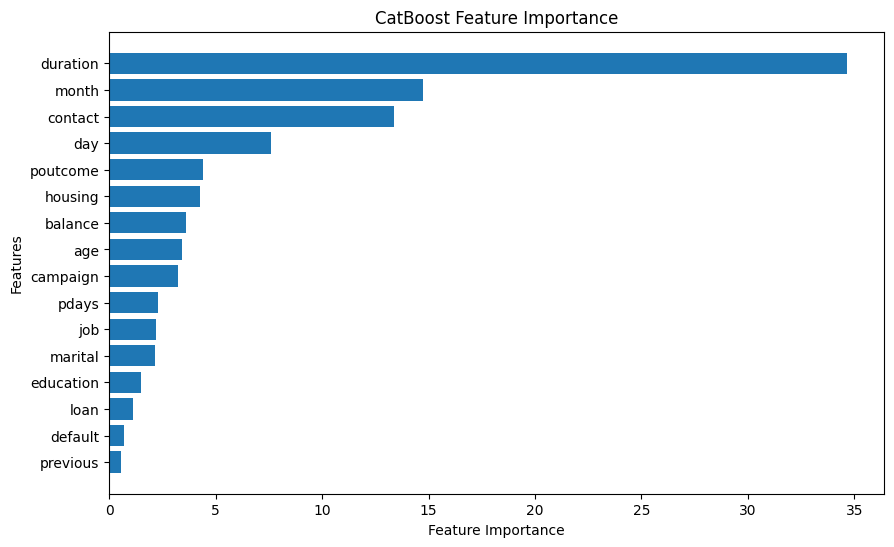

In [22]:
feature_importance = model.get_feature_importance()
feature_names = X.columns

# Create DataFrame for plotting
fi_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
fi_df = fi_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(fi_df['feature'], fi_df['importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis() # Highest importance at top
plt.show()

## 7. SHAP Explanations
We compute SHAP values using CatBoost's native SHAP implementation (fast + stable), then visualize:
- Global importance (beeswarm + bar)
- Local explanation (waterfall) for a selected sample
- Optional: explain a False Negative under a chosen decision threshold

In [23]:
from catboost import Pool
import shap

/Users/haoyuli/Desktop/Master_Semester_2/Agentic_Explainable_AI_PwC/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
test_pool = Pool(X_test, y_test, cat_features=cat_features)

# Shap Values: (n_samples, n_features+1), where the last column is the expected value (base value)
shap_vals = model.get_feature_importance(test_pool, type="ShapValues")

shap_values = shap_vals[:, :-1]
base_values = shap_vals[:, -1]

print("shap_values:", shap_values.shape)
print("base_values:", base_values.shape)

shap_values: (9042, 16)
base_values: (9042,)


### Global Explanation: Beeswarm

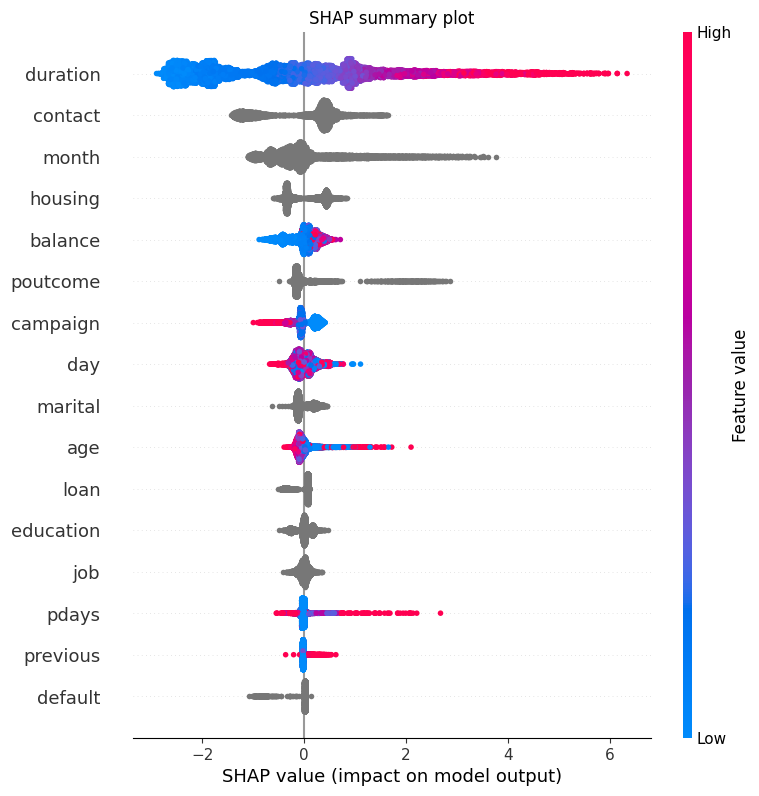

In [25]:
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP summary plot")
plt.show()

### Global Explanation: Mean absolute SHAP Values

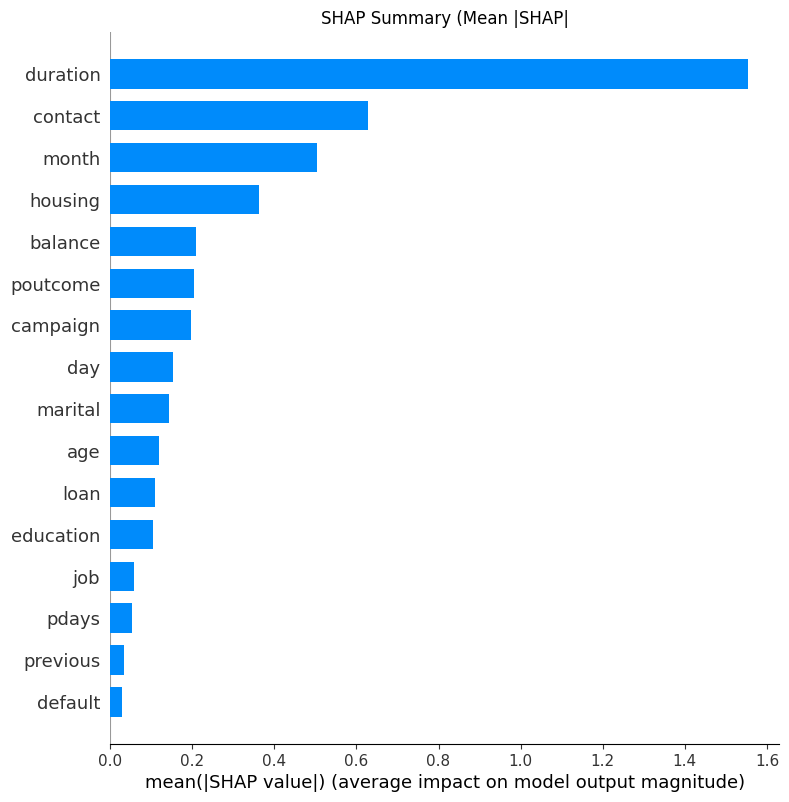

In [26]:
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("SHAP Summary (Mean |SHAP|")
plt.show()

## Lime Explanation

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

feature_names = list(X_train.columns)

cat_cols = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
num_cols = [c for c in feature_names if c not in cat_cols]

# 用 OrdinalEncoder：把每个类别列编码为 0..K-1
enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

X_train_enc = X_train.copy()
X_test_enc  = X_test.copy()

X_train_enc[cat_cols] = enc.fit_transform(X_train[cat_cols].astype(str))
X_test_enc[cat_cols]  = enc.transform(X_test[cat_cols].astype(str))

# categorical 索引（基于同样的 feature_names）
cat_idx = [feature_names.index(c) for c in cat_cols]

# 给 LIME 用的 categorical_names（把编码值映射回原类别名，方便展示）
categorical_names = {}
for j, col in enumerate(cat_cols):
    # enc.categories_[j] 是该列的类别列表（按编码顺序）
    categorical_names[feature_names.index(col)] = [str(v) for v in enc.categories_[j]]

In [36]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(
    training_data=X_train_enc.values.astype(float),
    feature_names=feature_names,
    class_names=["no", "yes"],
    mode="classification",
    categorical_features=cat_idx,
    categorical_names=categorical_names,
    discretize_continuous=True,
    random_state=42
)

In [37]:
def predict_proba_lime(x_np: np.ndarray) -> np.ndarray:
    x_df_enc = pd.DataFrame(x_np, columns=feature_names)

    # 还原类别列：编码 -> 原类别字符串
    x_cat_enc = x_df_enc[cat_cols].values
    x_df_enc[cat_cols] = enc.inverse_transform(x_cat_enc).astype(str)

    pool = Pool(x_df_enc, cat_features=cat_idx)
    return model.predict_proba(pool)

In [ ]:
idx = 0
exp = explainer.explain_instance(
    data_row=X_test_enc.iloc[idx].values.astype(float),
    predict_fn=predict_proba_lime,
    num_features=10,
    num_samples=3000
)

exp.as_list(label=1)

[('default=no', 0.0602105896986764),
 ('job=entrepreneur', -0.059136583893684785),
 ('education=primary', -0.047566396290692724),
 ('poutcome=unknown', -0.04546651259690646),
 ('contact=cellular', 0.04312277392459775),
 ('180.00 < duration <= 319.00', -0.03703583764886828),
 ('marital=married', -0.03297303538264934),
 ('housing=yes', -0.02850200320443882),
 ('campaign <= 1.00', 0.028414207886276764),
 ('16.00 < day <= 21.00', -0.02598008368317168)]

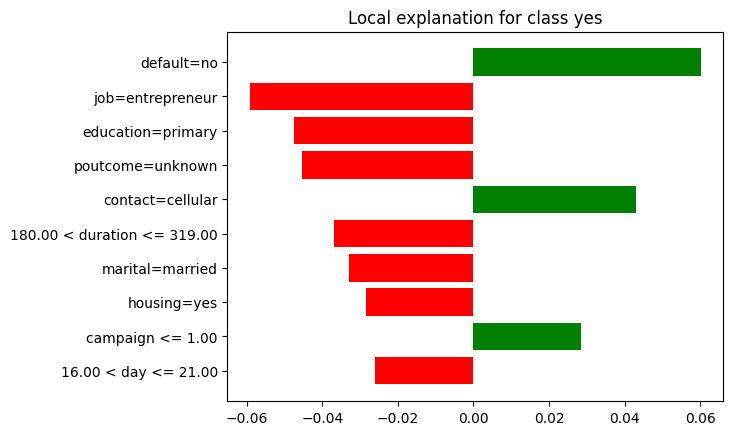

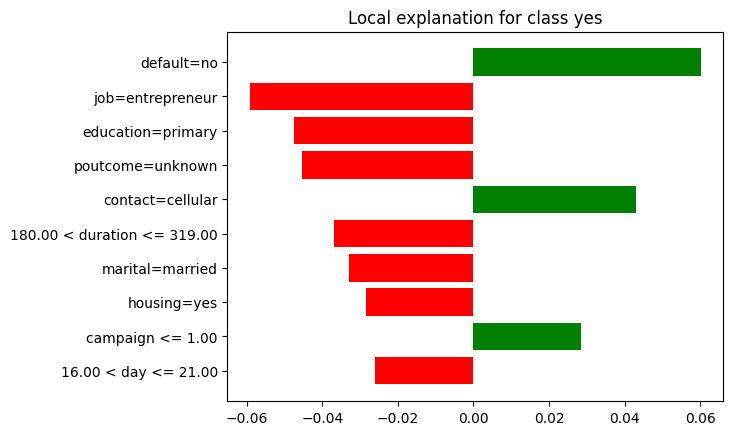

In [41]:
exp.as_pyplot_figure(label=1)

### Local Explanation on single sample

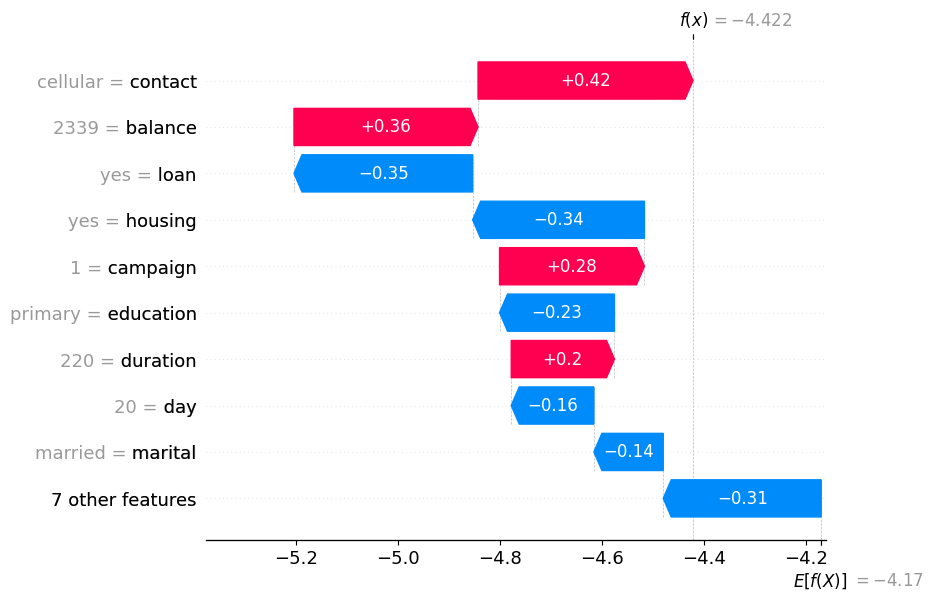

In [17]:
i = 0
exp = shap.Explanation(
    values = shap_values[i],
    base_values = base_values[i],
    data = X_test.iloc[i],
    feature_names = X_test.columns,
)
shap.plots.waterfall(exp)

## 8. Counterfactual Analysis

In [18]:
t = 0.2
y_pred_t = (y_pred > t).astype(int)

# FP: true=0, pred=1
fp_idx = np.where((y_test.values == 0) & (y_pred_t == 1))[0]

# TP: true=1, pred=1
tp_idx = np.where((y_test.values == 1) & (y_pred_t == 1))[0]

# TN: true=0, pred=0
tn_idx = np.where((y_test.values == 0) & (y_pred_t == 0))[0]

# FN: true=1, pred=0
fn_idx = np.where((y_test.values == 1) & (y_pred_t == 0))[0]

print("Number of FP:", len(fp_idx))
print("Number of TP:", len(tp_idx))
print("Number of TN:", len(tn_idx))
print("Number of FN:", len(fn_idx))

Number of FP: 263
Number of TP: 519
Number of TN: 7721
Number of FN: 539


### 8.1 Similarity Analysis with KNN & LLM

First of all, it is helpful to look at **real existing customers** who are similar to our target but had a positive outcome. We use **K-Nearest Neighbors (KNN)** to find these "successful" peers and then use an **LLM (OpenAI)** to generate a narrative comparison.

In [19]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd

# Prepare Data for KNN (One-Hot Encoding for categorical features)
X_train_encoded = pd.get_dummies(X_train, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# Ensure columns match (training set might have difference due to dummy encoding)
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Filter for Positive Samples (Target = 1) in Training Data
X_train_pos = X_train_encoded[y_train == 1]
# Keep raw version for display (using the original index)
X_train_pos_raw = X_train.loc[X_train_pos.index]

### KNN

In [20]:
# Fit KNN on Positive Samples
knn = NearestNeighbors(n_neighbors=5, metric='minkowski', p=2)
knn.fit(X_train_pos)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"radius radius: float, default=1.0Range of parameter space to use by default for :meth:`radius_neighbors`queries.",1.0
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"p p: float (positive), default=2Parameter for the Minkowski metric fromsklearn.metrics.pairwise.pairwise_distances. When p = 1, this isequivalent to using manhattan_distance (l1), and euclidean_distance(l2) for p = 2. For arbitrary p, minkowski_distance (l_p) is used.",2
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None


In [21]:
# Get Query Instance
tn_row = X_test.iloc[tn_idx[1]]
query_instance = tn_row.to_frame().T

# It's a single row DataFrame, encoded it similarly
query_instance_encoded = pd.get_dummies(query_instance, drop_first=True)
query_instance_encoded = query_instance_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Find Neighbors
distances, indices = knn.kneighbors(query_instance_encoded)
neighbors_raw = X_train_pos_raw.iloc[indices[0]]

print("Query Instance (Negative Result):")
display(query_instance)
print("\nNearest Positive Neighbors (Real Customers):")
display(neighbors_raw)

Query Instance (Negative Result):


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
3081,43,services,divorced,secondary,no,206,yes,no,unknown,14,may,436,1,-1,0,unknown



Nearest Positive Neighbors (Real Customers):


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
31251,27,student,single,tertiary,no,0,no,no,cellular,5,mar,82,3,-1,0,unknown
32194,35,management,divorced,tertiary,no,26,no,no,cellular,16,apr,78,2,-1,0,unknown
33399,50,self-employed,divorced,tertiary,no,13,yes,no,cellular,20,apr,76,1,-1,0,unknown
31326,53,services,divorced,secondary,no,0,no,no,cellular,12,mar,80,2,-1,0,unknown
33768,35,management,married,tertiary,no,8,no,no,cellular,23,apr,93,3,-1,0,unknown


In [ ]:
import openai

openai.api_key = os.getenv("OPENAI_API_KEY")

def analyze_with_llm(target, neighbors):
    if not openai.api_key:
        return "Error: OpenAI API Key not set. Please set os.environ['OPENAI_API_KEY'] or openai.api_key."
        
    # Convert dataframes to string for the prompt
    target_str = target.to_string(index=False)
    neighbors_str = neighbors.to_string(index=False)
    
    prompt = f"""
    You are a bank marketing analyst. 

    This is the description of each feature in the dataset:
    {explanation}
    
    TARGET CUSTOMER (Did NOT subscribe):
    {target_str}
    
    SIMILAR SUCCESSFUL CUSTOMERS (DID subscribe):
    {neighbors_str}
    
    Analyze the difference between the target customer and the similar successful customers.
    Accoridng to the feature explanations, identify key actionable factors that can be changed from the bank's perspective and might explain why the successful ones subscribed.
    Also, in the end, provide a list of features that can be changed for later DICE counterfactual analysis.
    """
    
    try:
        response = openai.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are a helpful data analyst helper."}, 
                {"role": "user", "content": prompt}
            ],
            temperature=0.2
        )
        return response.choices[0].message.content
    except Exception as e:
        return f"OpenAI API Error: {str(e)}"

# Run Analysis
if 'neighbors_raw' in locals():
    analysis_result = analyze_with_llm(query_instance, neighbors_raw)
    print("\n--- LLM Analysis ---\n")
    print(analysis_result)
else:
    print("Neighbors not found. Please run the KNN cell first.")


--- LLM Analysis ---

To analyze the differences between the target customer who did not subscribe and the similar successful customers who did subscribe, we can examine the features and identify actionable factors that might explain the differences in outcomes. Here are the key differences and actionable insights:

1. **Contact Method:**
   - **Target Customer:** Contact method is "unknown."
   - **Successful Customers:** Contact method is "cellular."
   - **Actionable Insight:** The bank should prioritize contacting customers through cellular methods, as this seems to be associated with higher subscription rates.

2. **Duration of Last Contact:**
   - **Target Customer:** Duration is 436 seconds.
   - **Successful Customers:** Durations are shorter, ranging from 76 to 93 seconds.
   - **Actionable Insight:** While longer call durations might seem beneficial, the successful customers had shorter calls. The bank should focus on making calls more concise and effective.

3. **Campaign C

### 8.2 DICE

In [25]:
import dice_ml
from dice_ml import Dice

data = dice_ml.Data(
    dataframe=df,
    continuous_features=[
        "age", "balance", "campaign", "duration", "pdays", "previous"
    ],
    categorical_features=[
        "job", "marital", "education", "default",
        "housing", "loan", "contact", "month", "poutcome"
    ],
    outcome_name="y"
)

model_dice = dice_ml.Model(
    model = model, 
    backend = 'sklearn',
    model_type = 'classifier'
)

dice = Dice(data, model_dice, method="random")

In [26]:
cf = dice.generate_counterfactuals(
    query_instance,
    total_CFs=5,
    desired_class=1,
    features_to_vary=[
        "campaign", "contact", "month" 
    ]
)

cf.visualize_as_dataframe()

100%|██████████| 1/1 [00:00<00:00, 10.35it/s]

Query instance (original outcome : 0)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,43,services,divorced,secondary,no,206,yes,no,unknown,14,may,436,1,-1,0,unknown,0



Diverse Counterfactual set (new outcome: 1)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,43,services,divorced,secondary,no,206,yes,no,cellular,14,jun,436,1,-1,0,unknown,1
1,43,services,divorced,secondary,no,206,yes,no,unknown,14,mar,436,1,-1,0,unknown,1
2,43,services,divorced,secondary,no,206,yes,no,unknown,14,mar,436,5.0,-1,0,unknown,1
3,43,services,divorced,secondary,no,206,yes,no,unknown,14,dec,436,6.0,-1,0,unknown,1
4,43,services,divorced,secondary,no,206,yes,no,unknown,14,sep,436,58.0,-1,0,unknown,1


In [27]:
cfs_df = cf.cf_examples_list[0].final_cfs_df.copy()

In [28]:
def analyze_dice_results(target_df, dice_cf_obj, allowed_features=None):
    """
    target_df: 1-row DataFrame (target customer)
    dice_cf_obj: output of dice.generate_counterfactuals(...)
    allowed_features: list like ["campaign", "contact", "month"]
    """

    if allowed_features is None:
        allowed_features = dice_cf_obj.feature_names
    if not os.getenv("OPENAI_API_KEY"):
        return "Error: OPENAI_API_KEY not set."
    
    cfs_df = dice_cf_obj.cf_examples_list[0].final_cfs_df.copy()
    target_str = target_df.to_string(index=False)
    cfs_str = cfs_df.to_string(index=False)

    prompt = f"""
    You are a bank marketing analyst.

    This is the description of each feature in the dataset:
    {explanation}

    TARGET CUSTOMER (model predicted: NOT subscribe):
    {target_str}

    DICE COUNTERFACTUAL SET (model predicted: subscribe after changes):
    {cfs_str}

    Allowed features to alter: {allowed_features}

    Task:
    1) Compare each counterfactual example to the target customer and check what changed.
    2) Evaluate feasibility for EACH counterfactual, under real banking operations:
    - Only allowed to change the features in {allowed_features}.
    - Prefer minimal changes (change as few features as possible).
    - Reject changes that are not actionable or not feasible in the real-world settings.
    3) Select the SINGLE most feasible counterfactual and explain why it is best.
    4) Provide concise, actionable strategies the bank agent should adopt.

    Output format (plain text, concise):
    - Summary
    - Feasibility ranking (best → worst) with brief reasons
    - Best counterfactual (show changes)
    - Agent strategy recommendations (bullets)
    """

    try:
        resp = openai.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You are a helpful banking analytics assistant."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.2
        )
        return resp.choices[0].message.content
    except Exception as e:
        return f"OpenAI API Error: {str(e)}"

In [29]:
result = analyze_dice_results(query_instance, cf, allowed_features=["campaign", "contact", "month"])
print("\n--- LLM Analysis of DiCE Counterfactuals ---\n")
print(result)


--- LLM Analysis of DiCE Counterfactuals ---

**Summary:**
The target customer is a 43-year-old divorced individual with a secondary education, no credit default, a balance of 206, and no personal loan. The counterfactuals suggest changes in the features of 'campaign', 'contact', and 'month' to potentially increase the likelihood of subscribing to a term deposit. 

**Feasibility Ranking (best → worst):**
1. **Counterfactual 1: Change contact to 'cellular', month to 'jun'**
   - Minimal changes (only 2 features).
   - 'Cellular' is a common and actionable contact method.
   - June is a reasonable month for follow-up.
  
2. **Counterfactual 2: Change contact to 'unknown', month to 'mar'**
   - Minimal changes (only 2 features).
   - 'Unknown' is less actionable but still feasible.
   - March is a reasonable month for follow-up.
  
3. **Counterfactual 3: Change contact to 'unknown', month to 'mar', campaign to 5.0**
   - More changes (3 features).
   - Increasing campaign contacts may no

### Next Steps: Agentic Framework